In [2]:
#Train CNN for prediction of subcellular localization prediction
import os
os.chdir('/home/azamh/bioinf')
import sys
from utils.parse_data import *
from utils.rep3d import *
from utils.visuallize import *
from script.models import *
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
torch.backends.cudnn.benchmark = True
from sklearn.metrics import accuracy_score, matthews_corrcoef, classification_report


%load_ext autoreload
%autoreload 2

/home/azamh/anaconda3/envs/pyuul/envs/esm/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#Get device 
device = get_device()
print(device)

NVIDIA GeForce RTX 2080 Ti
cuda


In [4]:
#Read in deeploc dataset
deeploc_df = read_deep_loc()
deeploc_df

,Protein,Sequence,Location,Extra Location,Split,Location Label
8557,P07834,MGSFPLAEFPLRDIPVPYSYRVSGGIASSGSVTALVTAAGTHRNSS...,Nucleus,U,train,0
10700,Q9DA32,MPRTRNIGALCTLPEDTTHSGRPRRGVQRSYISRMAEPAPANMNDP...,Nucleus,M,train,0
10701,O42927,MNPTSFIYDKPPPPPIINKPFEQTNSSASLTQKNSSSETENVGRHG...,Nucleus,U,test,0
10702,Q38CE9,MVVLRPKITLTSVRGRIQVTAEDGERVGPWGGTECFLSRQTGQGPC...,Nucleus,U,train,0
10703,Q06554,MSAVGALLAREYNVTAEKCDFFLENGSFDSVIAALPALNQEQETVT...,Nucleus,U,train,0
...,...,...,...,...,...,...
11074,Q9LRS0,MEITNVTEYDAIAKAKLPKMVYDYYASGAEDQWTLQENRNAFARIL...,Peroxisome,U,train,9
11073,A2AKK5,MMIKLIATPSNALVDEPVSIRATGLPPSQIVTIKATVKDENDNVFQ...,Peroxisome,U,train,9
11072,Q02969,MSQFGTTDIVSGSETPPYSGASYQDAQDDNTHPHSSDAGAEKFSAG...,Peroxisome,M,train,9
11079,O74936,MISPNLTANVEIDGKQYNTFTEPPKALAGERAKVKFPIKDMTEFLH...,Peroxisome,U,train,9


In [5]:
#Add AF2 models to deeploc dataset
deeploc_af2_df = get_deep_loc_af2(deeploc_df)
deeploc_af2_df

,Protein,Sequence,Location,Extra Location,Split,Location Label,PDB Path
8557,P07834,MGSFPLAEFPLRDIPVPYSYRVSGGIASSGSVTALVTAAGTHRNSS...,Nucleus,U,train,0,data/deeploc_af2/AF-P07834-F1-model_v4.pdb
10700,Q9DA32,MPRTRNIGALCTLPEDTTHSGRPRRGVQRSYISRMAEPAPANMNDP...,Nucleus,M,train,0,data/deeploc_af2/AF-Q9DA32-F1-model_v4.pdb
10701,O42927,MNPTSFIYDKPPPPPIINKPFEQTNSSASLTQKNSSSETENVGRHG...,Nucleus,U,test,0,data/deeploc_af2/AF-O42927-F1-model_v4.pdb
10702,Q38CE9,MVVLRPKITLTSVRGRIQVTAEDGERVGPWGGTECFLSRQTGQGPC...,Nucleus,U,train,0,data/deeploc_af2/AF-Q38CE9-F1-model_v4.pdb
10703,Q06554,MSAVGALLAREYNVTAEKCDFFLENGSFDSVIAALPALNQEQETVT...,Nucleus,U,train,0,data/deeploc_af2/AF-Q06554-F1-model_v4.pdb
...,...,...,...,...,...,...,...
11074,Q9LRS0,MEITNVTEYDAIAKAKLPKMVYDYYASGAEDQWTLQENRNAFARIL...,Peroxisome,U,train,9,data/deeploc_af2/AF-Q9LRS0-F1-model_v4.pdb
11073,A2AKK5,MMIKLIATPSNALVDEPVSIRATGLPPSQIVTIKATVKDENDNVFQ...,Peroxisome,U,train,9,data/deeploc_af2/AF-A2AKK5-F1-model_v4.pdb
11072,Q02969,MSQFGTTDIVSGSETPPYSGASYQDAQDDNTHPHSSDAGAEKFSAG...,Peroxisome,M,train,9,data/deeploc_af2/AF-Q02969-F1-model_v4.pdb
11079,O74936,MISPNLTANVEIDGKQYNTFTEPPKALAGERAKVKFPIKDMTEFLH...,Peroxisome,U,train,9,data/deeploc_af2/AF-O74936-F1-model_v4.pdb


train    11085
test      2773
Name: Split, dtype: int64


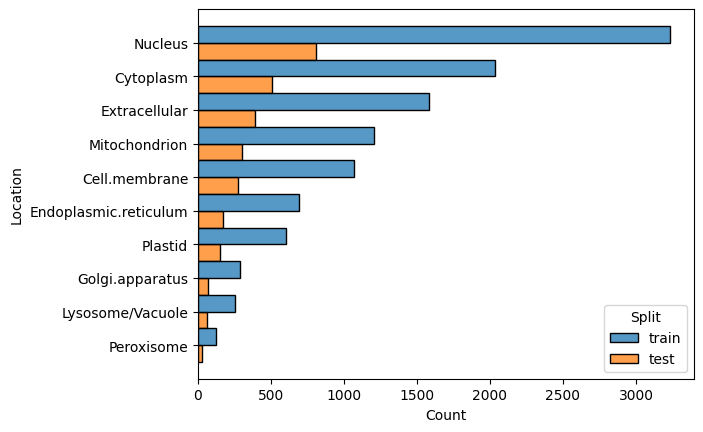

In [6]:
#Plot original data
sns.histplot(data = deeploc_df, y = 'Location', hue = 'Split', multiple = 'dodge', hue_order = ['train', 'test'])
print(deeploc_df['Split'].value_counts())


train    10958
test      2749
Name: Split, dtype: int64


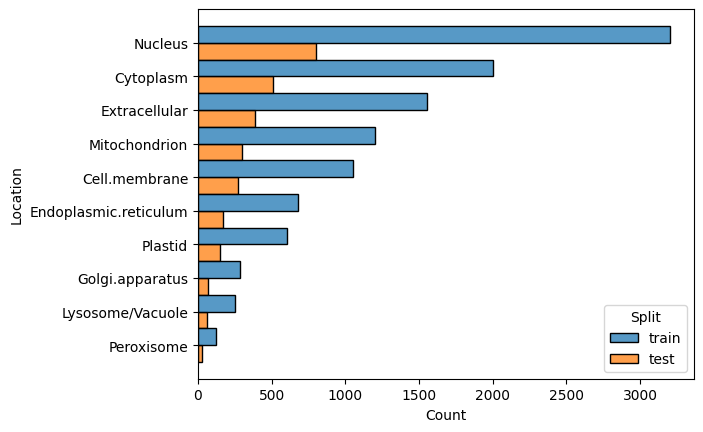

In [7]:
#Plot data with Af2 models
sns.histplot(data = deeploc_af2_df, y = 'Location', hue = 'Split', multiple = 'dodge', hue_order = ['train', 'test'])
print(deeploc_af2_df['Split'].value_counts())

In [8]:
#Voxel params
hashing = "Element_Hashing"
resolution = 1
rep = 'voxel'

In [9]:
#Get mean size of voxel
#get_mean_dimensions(deeploc_af2_df)

#Mean: [1 ,  4.99897862, 110.35470927,  94.31195739, 111.42883198]

In [10]:
#visuallize example
example_protein = 'Q06554'
example_pdb_path = 'data/deeploc_af2/AF-Q06554-F1-model_v4.pdb'
visuallize_pdb(example_pdb_path)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
#Visuallize example voxel
example_voxel = rep_protein(example_pdb_path, device, rep = rep, hashing = hashing, resolution = resolution)
print(example_voxel.shape)
plot_voxel_scatter(to_numpy(example_voxel), 0)

torch.Size([1, 5, 143, 144, 145])


In [ ]:
#Resize example
resized_example_voxel = resize_grid(example_voxel.to_dense(), device, 5, 110, 110, 110)
print(resized_example_voxel.shape)
plot_voxel_scatter(to_numpy(resized_example_voxel), 0)

In [ ]:
#Generate resized voxels and save to file
deeploc_af2_df['Voxel Path'] = ''
voxel_dir = 'voxels/deeploc'
os.makedirs(voxel_dir, exist_ok = True)
for i in range(len(deeploc_af2_df)):
    if i % 1000 == 0: print(i)
    protein_path = deeploc_af2_df['PDB Path'].iloc[i]
    protein = deeploc_af2_df['Protein'].iloc[i]
    voxel_path = os.path.join(voxel_dir, f'{protein}.pt')
    deeploc_af2_df['Voxel Path'].iloc[i] = voxel_path
    
    #Generate voxel
    if not os.path.isfile(voxel_path):
        voxel = rep_protein(protein_path, device, rep = rep, hashing = hashing, resolution = resolution)
        resized_voxel = resize_grid(voxel.to_dense(), device, 5, 110, 110, 110)
        torch.save(resized_voxel.cpu(), voxel_path)
        

In [ ]:
#Create dataloader 
pin_memory = True
if device == 'cpu':
    pin_memory = False
num_workers = 0
batch_size = 32
train_deeploc_af2_df, test_deeploc_af2_df = split_deeploc(deeploc_af2_df)
trainset = VoxelDataset(list(train_deeploc_af2_df['Voxel Path']), list(train_deeploc_af2_df['Location Label']))
testset = VoxelDataset(list(test_deeploc_af2_df['Voxel Path']), list(test_deeploc_af2_df['Location Label']))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers = num_workers, pin_memory=pin_memory)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=True, num_workers = num_workers, pin_memory=pin_memory) 

In [ ]:
# Create CNN
model = nn.DataParallel(alex_3d(in_channels = 5, num_classes = 10))
if torch.cuda.is_available():
    model.cuda()
    print('N Gpus:', torch.cuda.device_count())

# Cross Entropy Loss 
loss_fn = nn.CrossEntropyLoss()

# SGD Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = .01)

In [ ]:
# CNN model training
model_save_path = 'models/alex_3d'
epochs = 100

train_model(model, 
            epochs, 
            model_save_path, 
            trainloader,
            testloader,
            optimizer,
            loss_fn,
            device)



In [ ]:
#Evaluate performance
trained_epochs = 100

for epoch in range(trained_epochs):
    epoch_results_path  = os.path.join(model_save_path, f'{epoch}_results.pt')
    epoch_results_dict = torch.load(epoch_results_path)
    
    #Get mean loss
    mean_train_loss = np.mean(epoch_results_dict['training_losses'])
    mean_test_loss = np.mean(epoch_results_dict['test_losses'])
    print(mean_train_loss, mean_test_loss)
